In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
import mplhep as hep
hep.style.use("ATLAS")
# sys.path.append("../DataProcessing")
import ReweightMCDataLoading as rmc
sys.path.append("../Plotting")
import Utils as ut
sys.path.append("../")
import dataloader


new_mc_name = "PYTHIA8"


2025-04-30 06:24:13.795792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-30 06:24:13.943278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-30 06:24:13.984245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-30 06:24:14.261032: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-30 06:24:16.147147: W tensorflow/compiler/tf2

In [2]:
# load particle level distributions
aleph_mc = rmc.loadDataParticles(
        filePath = rmc.mc_paths["ArchivedPYTHIA6"]["path"],
        treeName = rmc.mc_paths["ArchivedPYTHIA6"]["tree"],
        branches = rmc.mc_paths["ArchivedPYTHIA6"]["branches"],
        maxNPart = 80
    )
print(aleph_mc.shape)

new_mc = rmc.loadDataParticles(
    filePath = rmc.mc_paths[new_mc_name]["path"], 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = rmc.mc_paths[new_mc_name]["branches"],
    maxNPart = 80
)
print(new_mc.shape)

(973769, 80, 3)
(5000000, 80, 3)


In [3]:
aleph_mc = rmc.convert_PxPyPz_to_EtaPhiPmag(aleph_mc)
new_mc = rmc.convert_PxPyPz_to_EtaPhiPmag(new_mc)

In [4]:
thrust_branches = ["Thrust"]

# load thrust distributions
reco_data, reco_mc, gen_mc, pass_reco, pass_gen = dataloader.DataLoader({
    "f_data": "/global/homes/b/badea/aleph/data/ThrustDerivation/030725/LEP1Data1994_recons_aftercut-MERGED_thrust.root",
    "f_mc": rmc.mc_paths["ArchivedPYTHIA6"]["path"], # thrust_path
    "SystematicVariation": 0,
})

# load thrust distributions
aleph_mc_thrust = rmc.loadData(
    filePath = rmc.mc_paths["ArchivedPYTHIA6"]["path"], # thrust_path
    treeName = rmc.mc_paths["ArchivedPYTHIA6"]["tree"], 
    branches = thrust_branches, 
)
print(aleph_mc_thrust.shape)

new_mc_thrust = rmc.loadData(
    filePath = rmc.mc_paths[new_mc_name]["path"], #.replace(".root", "_thrust.root"), 
    treeName = rmc.mc_paths[new_mc_name]["tree"],
    branches = thrust_branches,
)
print(new_mc_thrust.shape)

# convert to log(1-T)
aleph_mc_thrust = np.log(1-aleph_mc_thrust).flatten()
new_mc_thrust = np.log(1-new_mc_thrust).flatten()

(973769, 1)
(5000000, 1)


1 (973769,) (973769, 80, 1)


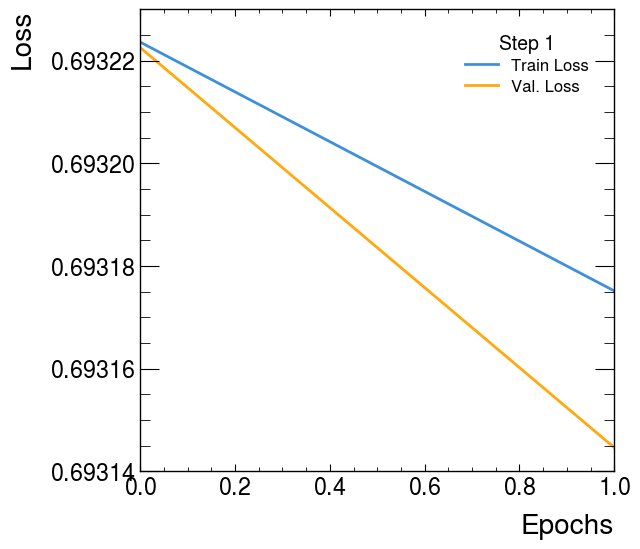

2 (973769,) (973769, 80, 1)


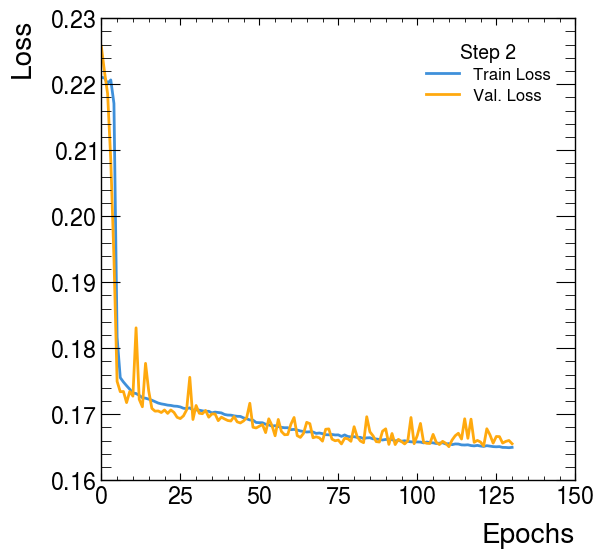

In [ ]:
# training_dir = "training-0eeee3d7/609ff241/model_weights_b22f1cf8" # pre gen cleaning training dir 
training_dir = "training-dcb1df64/38187555/model_weights_fe518abe/" # with gen cleaning
reweight = {}

for i in [1, 2]:
    inFileName = f"/pscratch/sd/b/badea/aleph/unfold-ee-logtau/ReweightMC/results/{training_dir}/Reweight_Step{i}.reweight.npy"
    temp = np.load(inFileName)
    reweight[f"Step{i}"] = temp
    temp = np.tile(temp[:, np.newaxis, np.newaxis], (1, aleph_mc.shape[1], 1))
    reweight[f"Step{i}_tile"] = temp
    print(i, reweight[f"Step{i}"].shape, reweight[f"Step{i}_tile"].shape)

    # plot the loss
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    with open(inFileName.replace(".reweight.npy", ".pkl"), 'rb') as f:
        temp = pickle.load(f)
    train_loss = temp['loss']
    val_loss = temp['val_loss']
    epochs = list(range(0, len(train_loss)))
    ax.plot(epochs, train_loss, label=f'Train Loss')
    ax.plot(epochs, val_loss, label=f'Val. Loss')

    ax.legend(fontsize=12, ncol=1, loc="upper right", title=f"Step {i}")
    fig.savefig(f"plots/loss_step{i}.pdf", bbox_inches='tight')
    plt.show()


In [6]:
conf = {
    "pmag" : {
        "bins" : np.linspace(0, 50, 51),
        "ax1_ylim" : [10**-5, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$|p|$ [GeV]",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "eta" : {
        "bins" : np.linspace(-5, 5, 51),
        "ax1_ylim" : [10**-4, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$\eta$",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "phi" : {
        "bins" : np.linspace(-4, 4, 51),
        "ax1_ylim" : [10**-2, 10**0],
        "ax2_ylim" : [0.01, 1.99],
        "ax2_xlabel" : r"$\phi$",
        "legend_loc" : "upper right",
        "legend_bbox" : (0.99, 1),
    },
    "thrust" : {
        "bins" : np.linspace(-8, np.log(0.5), 51),
        "ax1_ylabel" : r"1/$\sigma$ d$\sigma$/dlog(1-T)",
        "ax1_yscale" : "log",
        "ax1_ylim" : [0.2*10**-5, 10**0],
        "ax2_ylim" : [0.01, 2.49],
        "ax2_xlabel" : "log(1-T)",
        "legend_loc" : "upper left",
        "legend_bbox" : (0.02, 1),
    }
}

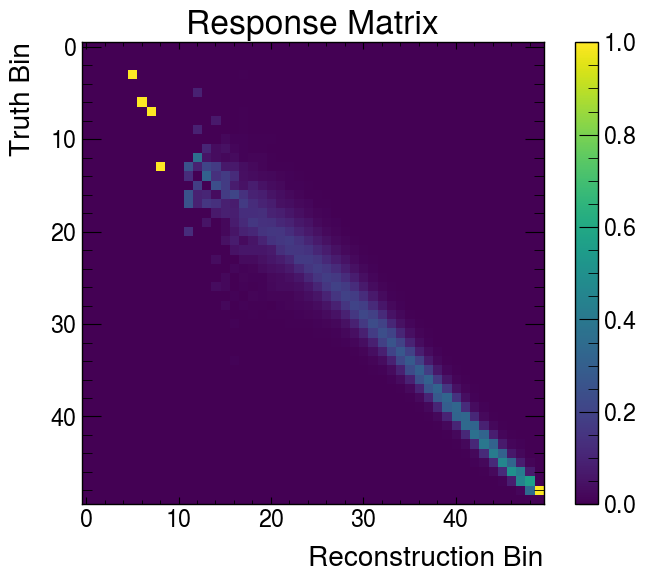

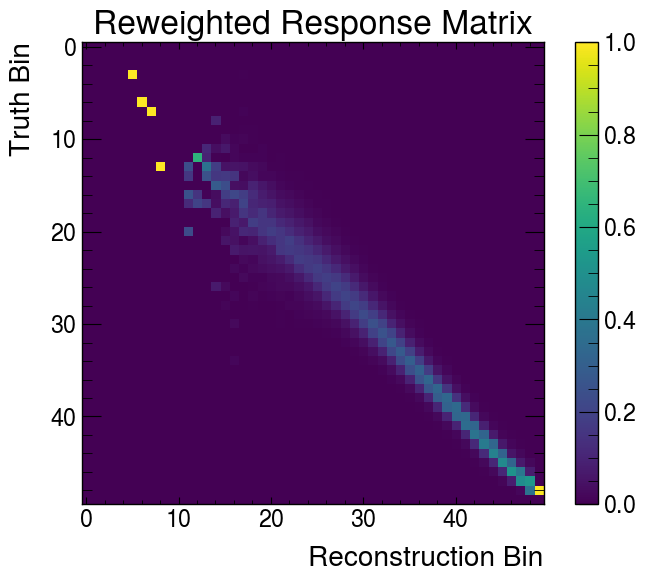

/tmp/ipykernel_2279954/1995035691.py:19: RuntimeWarning: invalid value encountered in divide
  plt.imshow(response1/response2, vmin = 0, vmax = 2)


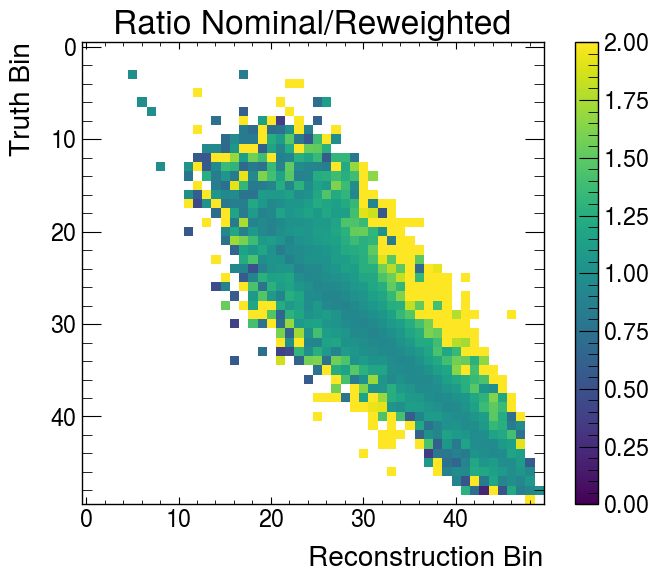

In [7]:
response1 = np.histogram2d(reco_mc[pass_reco].flatten(), gen_mc[pass_reco].flatten(), bins=(conf["thrust"]["bins"], conf["thrust"]["bins"]))[0]
response1 /= (response1.sum(axis=0) + 10**-50)
plt.imshow(response1, vmin = 0, vmax = 1)
plt.xlabel("Reconstruction Bin")
plt.ylabel("Truth Bin")
plt.title("Response Matrix")
plt.colorbar()
plt.show()

response2 = np.histogram2d(reco_mc[pass_reco].flatten(), gen_mc[pass_reco].flatten(), bins=(conf["thrust"]["bins"], conf["thrust"]["bins"]), weights=reweight[f"Step2"][pass_reco])[0]
response2 /= (response2.sum(axis=0) + 10**-50)
plt.imshow(response2, vmin = 0, vmax = 1)
plt.xlabel("Reconstruction Bin")
plt.ylabel("Truth Bin")
plt.title("Reweighted Response Matrix")
plt.colorbar()
plt.show()

plt.imshow(response1/response2, vmin = 0, vmax = 2)
plt.xlabel("Reconstruction Bin")
plt.ylabel("Truth Bin")
plt.title("Ratio Nominal/Reweighted")
plt.colorbar()
plt.show()

In [8]:
plots = {}

branch = "thrust"
plots[branch] = {}
plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True)
plots[branch][f"h_aleph_mc_rw_step1"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True, weights=reweight["Step1"])
plots[branch][f"h_aleph_mc_rw_step2"] = ut.calc_hist(aleph_mc_thrust, bins=conf[branch]["bins"], density=True, weights=reweight[f"Step2"])
plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc_thrust, bins=conf[branch]["bins"], density=True)

branches = ["eta", "phi", "pmag"]
for iB, branch in enumerate(branches): #rmc.mc_paths[new_mc_name]["branches"]):
    plots[branch] = {}
    
    # aleph mc
    mask = ~np.isnan(aleph_mc[:,:,iB].flatten()) # != -999
    plots[branch][f"h_aleph_mc"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)
    plots[branch][f"h_aleph_mc_rw_step1"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight["Step1_tile"].flatten()[mask])
    plots[branch][f"h_aleph_mc_rw_step2"] = ut.calc_hist(aleph_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True, weights=reweight[f"Step2_tile"].flatten()[mask])
    # new mc
    mask = ~np.isnan(new_mc[:,:,iB].flatten()) # new_mc[:,:,iB].flatten() != -999
    plots[branch][f"h_new_mc"] = ut.calc_hist(new_mc[:,:,iB].flatten()[mask], bins=conf[branch]["bins"], density=True)

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  ratio = A / B
/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: divide by zero encountered in divide
  ratio = A / B


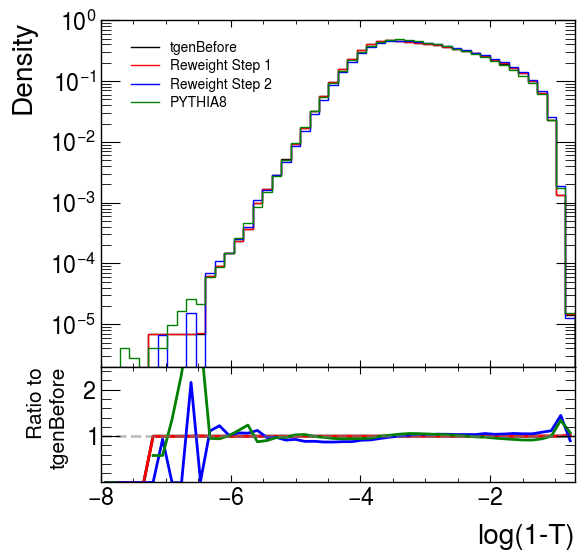

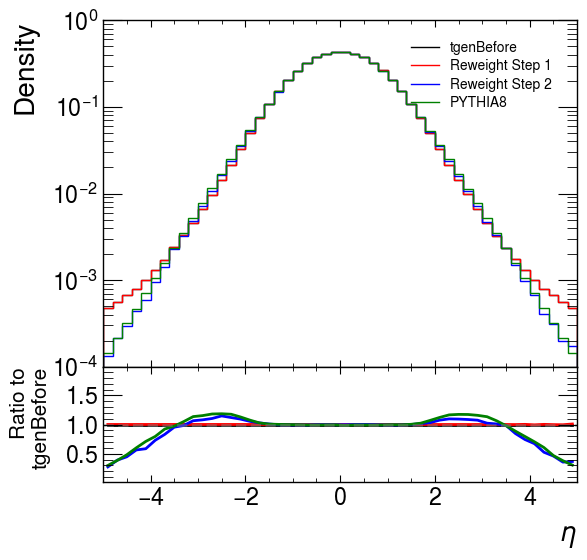

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


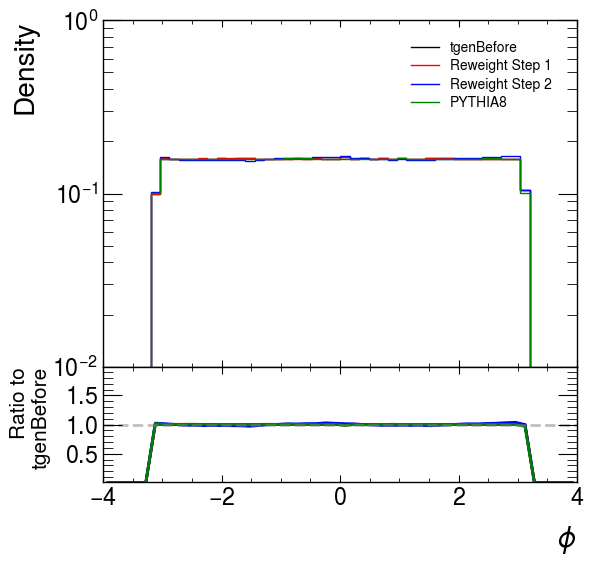

/global/u1/b/badea/aleph/unfold-ee-logtau/ReweightMC/../Plotting/Utils.py:144: RuntimeWarning: invalid value encountered in divide
  ratio = A / B


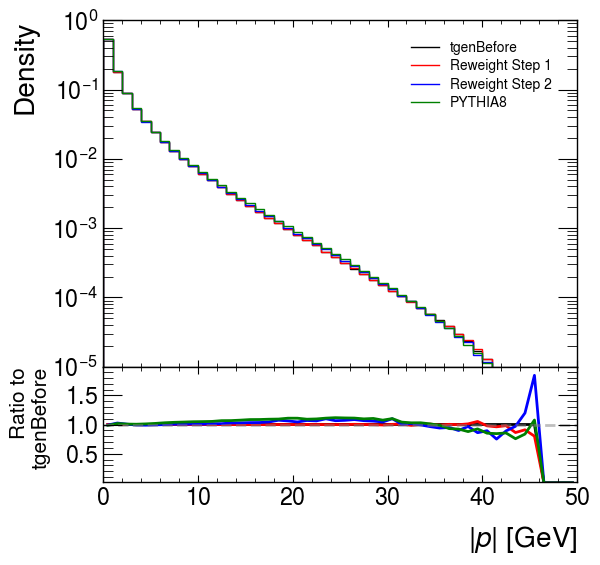

In [10]:
for key, val in plots.items():

    # style
    style = {
        "legend_loc" : conf[key]["legend_loc"],
        "legend_bbox" : conf[key]["legend_bbox"],
        "legend_ncol" : 1,
        "legend_fontsize" : 10,
        "ax1_ylabel" : "Density",
        "ax1_yscale" : "log",
        "ax2_xlabel" : conf[key]["ax2_xlabel"], #f"{key}" + (" [GeV]" if key in ["p"] else ""),
        "ax2_xscale" : "linear",
        "ax2_ylabel" : f'Ratio to\ntgenBefore',
        "ax1_ylim" : conf[key]["ax1_ylim"],
        "bins" : conf[key]["bins"],
        "ax2_ylim" : conf[key]["ax2_ylim"],
    }

    # plot
    inPlots = {}
    inPlots["tgenBefore"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc"][0], "color": "black", "label": "tgenBefore", "ls":"-"}
    inPlots["tgenBefore_rw_step1"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc_rw_step1"][0], "color": "red", "label": "Reweight Step 1", "ls":"-"}
    inPlots["tgenBefore_rw_step2"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_aleph_mc_rw_step2"][0], "color": "blue", "label": "Reweight Step 2", "ls":"-"}
    inPlots["new_mc"] = {"plotType": "stairs", "x": conf[key]["bins"], "y": val["h_new_mc"][0], "color": "green", "label": new_mc_name, "ls":"-"}

    # ratio denominator using the total error
    ratio_denom = [val["h_aleph_mc"]]

    fig, (ax1, ax2) = ut.plotThrust(style, inPlots, ratio_denom, epsilon = 1e-10)
    plt.show()
    fig.savefig(f"plots/{key}_reweight.pdf", bbox_inches='tight')
    plt.close()